In [101]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [102]:
df_raw = pd.read_csv('cl2.csv')

In [103]:
# df = df_raw[df_raw['REG_YYMM'].isin([202001, 202002, 202003])]
# df.head()

In [104]:
df = df_raw
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
0,201901,서울,기타 외국식 음식점업,10s,1,1,689,9131800,950,0
1,201901,서울,기타 외국식 음식점업,10s,2,1,314,3866150,375,0
2,201901,서울,기타 외국식 음식점업,20s,1,1,35290,676272038,44734,0
3,201901,서울,기타 외국식 음식점업,20s,1,2,1086,22468190,1393,0
4,201901,서울,기타 외국식 음식점업,20s,2,1,35298,645634640,41973,0


# Data Preprocessing

In [105]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [106]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [107]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [108]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [109]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
0,서울,기타 외국식 음식점업,10s,1,1,689,9131800,950,0,2019,1,Winter
1,서울,기타 외국식 음식점업,10s,2,1,314,3866150,375,0,2019,1,Winter
2,서울,기타 외국식 음식점업,20s,1,1,35290,676272038,44734,0,2019,1,Winter
3,서울,기타 외국식 음식점업,20s,1,2,1086,22468190,1393,0,2019,1,Winter
4,서울,기타 외국식 음식점업,20s,2,1,35298,645634640,41973,0,2019,1,Winter


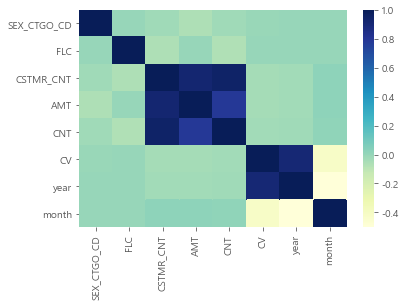

In [110]:
sns.heatmap(df.corr(),cmap='YlGnBu',fmt='.1g')

# Label Encoding

In [111]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CARD_SIDO_NM  3800 non-null   int32
 1   STD_CLSS_NM   3800 non-null   int32
 2   AGE           3800 non-null   int32
 3   SEX_CTGO_CD   3800 non-null   int64
 4   FLC           3800 non-null   int64
 5   CSTMR_CNT     3800 non-null   int64
 6   AMT           3800 non-null   int64
 7   CNT           3800 non-null   int64
 8   CV            3800 non-null   int64
 9   year          3800 non-null   int64
 10  month         3800 non-null   int64
 11  Season        3800 non-null   int32
dtypes: int32(4), int64(8)
memory usage: 297.0 KB


In [113]:
df.STD_CLSS_NM.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [114]:
df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

# Preprocessing

In [115]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [116]:
X = df.drop(['AMT'], axis=1)
y = np.log1p(df['AMT'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [117]:
# X = df.drop(['AMT'], axis=1)
# y = df[['month', 'AMT']]
# y['AMT'] = np.log1p(df['AMT'])
# X_train, X_test, y_train, y_test = X[X['month'].isin([1,2])], X[X['month']==3], y[y['month'].isin([1,2])]['AMT'], y[y['month']==3]['AMT']

# Light Gradient Boosting Machine

In [118]:
import lightgbm as lgb

In [119]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [120]:
params = {
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1        }

In [121]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.209846
[200]	valid_0's rmse: 0.203368
Early stopping, best iteration is:
[187]	valid_0's rmse: 0.202767


# Template

In [122]:
X.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT',
       'CNT', 'CV', 'year', 'month', 'Season'],
      dtype='object')

In [123]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [124]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,year,month,Season
0,0,0,0,1,1,2020,4,3
1,0,0,0,1,1,2020,4,1
2,0,0,0,1,1,2020,4,2
3,0,0,0,1,1,2020,4,0
4,0,0,0,1,1,2020,7,3
...,...,...,...,...,...,...,...,...
5595,0,9,6,2,5,2020,4,0
5596,0,9,6,2,5,2020,7,3
5597,0,9,6,2,5,2020,7,1
5598,0,9,6,2,5,2020,7,2


In [125]:
df2 = df[(df['year']==2020) & (df['month']==3)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [126]:
df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [127]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [128]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [129]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [130]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [131]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,기타 외국식 음식점업,2.117888e+09,7348439049,-71.179071
1,기타 주점업,3.426400e+09,1463780040,134.078894
2,마사지업,3.302402e+09,144174546,2190.558152
3,서양식 음식점업,3.755980e+09,33691383982,-88.851809
4,여관업,1.945935e+09,2293624372,-15.158936
5,일식 음식점업,1.730482e+09,14155708402,-87.775374
6,중식 음식점업,1.336930e+09,13327780001,-89.968848
7,택시 운송업,1.356643e+09,78532125499,-98.272500
8,한식 음식점업,1.495979e+09,147494192925,-98.985737
9,화장품 및 방향제 소매업,1.717729e+09,15531843111,-88.940596


In [100]:
temp.to_csv('./template2.csv',index=False, encoding='utf-8-sig')